In [99]:

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML
import numpy as np
import math
from math import inf
import csv

1958 extent: 3636 meters

In [100]:
class glacierSim():
    def __init__(self, ela=2000,valley_length=3668, time=500,save=10,gamma=0.01,quiet=True):
        #print("OBJ INIT")
        self.valley_length = valley_length
        self.run_time=0.0
        self.prev_display=0
        self.start_ela = ela #in m
        self.curr_ela=ela
        self.num_cells = 50 #set number of cells
        self.dx = self.valley_length/(self.num_cells-1) #cell width in m
        self.time = time #simulation time in years
        self.save = save #timestep interval in years
        self.frames = ((int)(self.time/self.save))+1 #number of frames the animation will run for
        self.ice = np.zeros(self.num_cells) #initialize ice
        self.q = np.zeros(self.num_cells+1) #initialize ice flux, need to have num_cells+1 to offset it from ice thickness for calculations
        self.x = np.linspace(0.5 * self.dx, self.valley_length - 0.5 * self.dx,self.num_cells) #used for plotting topography and ice thickness
        self.topo = [] #initialize topography
        self.g = 9.81 #gravity constant in m/yr^2
        self.p = 917 #density of ice
        self.b_max = float(-inf)
        self.b_min = float(inf)
        self.gamma = gamma #for mass balance equation
        self.ice_volume=0
        self.volume_change=[]
        self.initial_volume=0
        self.timestep_list=[]
        self.initial_run=False
        self.b=np.zeros(self.num_cells)
        self.glacier_extent=0
        self.ice_slope = np.zeros(self.num_cells, dtype=np.longdouble) #initialize ice_slope
        self.quiet=quiet
        self.glacier_extent=0
    
    def init(self, ax,ela=6700,valley_length=3668, time=500,save=10,gamma=0.008):
        #print("INIT")
        self.__init__(ela, valley_length, time, save, gamma)
        self.calc_topo()
        ax.clear()
        ax.set_ylim(min(self.topo) - 100, max(self.topo) + 100)
        ax.set_xlim(0, self.valley_length)
        ax.set_ylabel("Height (m)")
        ax.set_xlabel("Distance (m)")
        ax.set_aspect('equal', adjustable='datalim')
        ax.plot(self.x, self.topo, color="b", label="Topography")
        self.line = ax.plot(self.x, self.ice + self.topo, color="c", label="Ice Thickness")
        self.ela_line = ax.axhline(y=self.start_ela, color="r", linestyle="dashed", label="ELA")
        ax.legend()
    

[2100.         2070.27045191 2040.54090383 2016.09898503 1989.45230209
 1962.08872596 1937.53883174 1904.3014386  1881.49078333 1865.34276336
 1854.82244416 1852.37689456 1851.48500156 1846.38167664 1837.11606158
 1817.86765391 1791.64946859 1757.96429565 1753.4665011  1758.23171554
 1751.77463638 1744.53846003 1736.70544534 1726.39669014 1715.54023447
 1699.78698962 1684.74115421 1672.18814071 1661.93559927 1655.72656975
 1659.09169883 1672.12927311 1680.37143859 1685.42159186 1676.76111127
 1662.6189263  1655.21801504 1649.11427295 1646.33545659 1642.428558
 1628.47411464 1626.00839972 1623.5426848  1621.07696988 1618.61125497
 1616.14554005 1614.6971145  1614.13140966 1613.56570483 1613.        ]


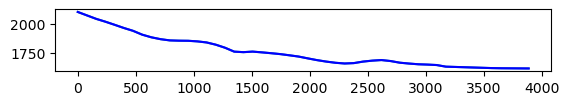

In [101]:
class glacierSim(glacierSim):
    def haversine(self, lat1, lon1, lat2, lon2):
        a = math.sin(math.radians(lat2 - lat1) / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos( math.radians(lat2)) * math.sin(math.radians(lon2 - lon1) / 2) ** 2
        return 6371000*(2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))
        
    def calc_topo(self):
        #print("CALC TOPO")
        latitudes = []
        longitudes = []
        with open('centerlineBed.csv', 'r', newline='') as file:
            reader = csv.reader(file)
            next(reader)  # Skip the header line
            for row in reader:
                latitudes.append(float(row[2]))    # Latitude is the second column
                longitudes.append(float(row[1]))   # Longitude is the third column
                self.topo.append(float(row[0]))
        cumulative_distances=[0]
        for i in range(1, len(latitudes)): cumulative_distances.append(cumulative_distances[-1] + self.haversine(latitudes[i - 1], longitudes[i - 1], latitudes[i], longitudes[i]) )
        self.x=np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells)
        self.topo=np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, self.topo)
        self.valley_length=max(np.max(self.x),100)
        self.default_b = True
        self.ice_slope[:-1] = abs((np.diff(self.topo)/ self.dx))
        #self.ice=np.exp(-0.5 * ((self.x - 700) / 300) ** 2)
        #scale=300/np.max(self.ice)
        #self.ice*=scale
        self.ice_volume=self.dx*np.sum(self.ice)
        self.initial_volume=self.ice_volume
        
glac=glacierSim()
glac.calc_topo()
print(glac.topo)
plt.plot(glac.x, glac.topo)
plt.plot(glac.x,glac.ice+glac.topo, color='b')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [102]:
class glacierSim(glacierSim):
    def update_b(self):
        return (self.topo+self.ice-self.curr_ela)*self.gamma

In [103]:
class glacierSim(glacierSim):
    def calc_q(self):
        self.ice_slope[:-1] = -(np.diff(self.ice+self.topo) / self.dx) #calculate ice slope
        if np.any(np.isnan(self.ice_slope)) and not self.quiet:
            print('NaN detected in ice_slope:', self.ice_slope)
            print("TIME: ", self.run_time)
            #plt.plot(self.x, self.ice+self.topo)
            plt.plot(self.timestep_list)
            return
        if np.any(np.isnan(self.ice)) and not self.quiet:
            print('NaN detected in ice:', self.ice)
            print("TIME: ", self.run_time)
            return
        if np.any(np.isinf(self.ice_slope)):
            print('Infinity detected in ice_slope:', self.ice_slope)
            print('Ice: ',self.ice)
            print("Q: ",self.q)
            print("TIME: ", self.run_time)
            plt.plot(self.timestep_list)
            return
        #self.q[1:] = (0.2 *(2e-17*2) * (self.p * self.g)**2) * np.sin(np.arctan(self.ice_slope))**2 * (self.ice**5)/5
        self.q[1:]=2e-17* ((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*((self.ice**5)/5)
        if np.any(np.isnan(self.q)) and not self.quiet:
            print('NaN detected in q:', self.q)
            print(self.ice_slope)
            print(self.ice)
            print("TIME: ", self.run_time)
            #plt.plot(self.x, self.ice+self.topo)
            plt.plot(self.timestep_list)
            return
        if (self.prev_display==0.0 or self.run_time>=self.prev_display+self.save) and self.run_time<self.time and not self.quiet:
            print("TIME: ", self.run_time)
            print("ELA: ", self.curr_ela)
            print("ICE: ",self.ice)
            print("ICE VOLUME: ",self.ice_volume/1e9, " km^3")
            print("Difference from inital volume: ", self.ice_volume/1e9-self.initial_volume/1e9, " km^3")
            self.volume_change.append(abs(self.ice_volume/1e9-self.initial_volume/1e9))
            print("SLOPE: ",self.ice_slope)
            print("MASS BALANCE: ", self.b)
            print("Q: ",self.q)
            print("DQDX: ",np.diff(self.q)/self.dx)
            print("SUM Q: ", np.sum(self.q))
            print("SUM DQDX: ",np.sum(np.diff(self.q)/self.dx))
            print()
            self.prev_display=self.run_time

        return self.ice_slope,(self.b-(np.diff(self.q)/self.dx)) #calculate the change in ice thickness and return it

    def report_final_values(self,u):
        ice_extent = self.x[self.ice > 1]
        if ice_extent.size > 0:
            self.glacier_extent=np.max(ice_extent)
            print("Final glacier length: " + str(np.max(ice_extent)) + 'm')
        else: print("Final glacier length: 0m (no ice extent)")
        print("Final max ice thickness: " + str(np.max(self.ice)) + 'm')
        print('Final max velocity: ' +str(np.max(u)) + "m/yr")
        if(self.default_b):
            print('B min: ' + str(self.b_min))
            print('B max: ' + str(self.b_max))

    def run_model(self,i):
        if i==0 and not self.initial_run:
            self.initial_run=True
            ax.clear()
            ax.set_ylim(min(self.topo) - 100, max(self.topo) + 100)
            ax.set_xlim(0, float(self.valley_length))
            ax.set_ylabel("Height (m)")
            ax.set_xlabel("Distance (m)")
            ax.set_aspect('equal', adjustable='datalim')
            ax.plot(self.x, self.topo, color="b", label="Topography")
            ax.set_title('Time = ' + str(round(self.run_time,(str(self.save)[::-1].find('.')+1))) + ' years')
            self.ela_line = ax.axhline(y=self.start_ela, color="r", linestyle="dashed", label="ELA")
            self.line = ax.plot(self.x, self.ice + self.topo, color="c", label="Ice")
            ax.legend()
        elif i>0.0:
            iter_time=0.0
            timestep=0.0
            while(iter_time<(self.save-timestep)):
                ice_slope,dqdx=self.calc_q()
                u = (2e-17)*((self.p*self.g*np.sin(np.arctan(ice_slope)))**3)*(((self.ice)**4)/5)
                timestep = np.clip(((self.dx / np.max(u)) * 0.2), 0.0001, 0.01) if np.any(u > 0) else 0.01
                self.timestep_list.append(timestep)
                self.ice = np.maximum((self.ice + dqdx * timestep), 0.0)
                self.ice_volume=self.dx*np.sum(self.ice)
                iter_time+=timestep
                self.run_time+=timestep
                self.b=self.update_b()
                self.b_max = max(np.max(self.b),self.b_max)
                self.b_min = min(np.min(self.b),self.b_min)
                
            ice_slope,dqdx=self.calc_q()
            timestep=abs(iter_time-self.save)
            self.timestep_list.append(timestep)
            self.ice = np.maximum((self.ice + dqdx * timestep), 0.0)
            self.ice_volume=self.dx*np.sum(self.ice)
            self.run_time+=timestep
            self.b=self.update_b()
            
            ax.clear()
            ax.set_ylim(min(self.topo) - 100, max(self.topo) + 100)
            ax.set_xlim(0, self.valley_length)
            ax.set_ylabel("Height (m)")
            ax.set_xlabel("Distance (m)")
            ax.set_aspect('equal', adjustable='datalim')
            ax.plot(self.x, self.topo, color="b", label="Topography")
            ax.set_title('Time = ' + str(round(self.run_time,(str(self.save)[::-1].find('.')+1))) + ' years')
            self.ela_line = ax.axhline(y=self.start_ela, color="r", linestyle="dashed", label="ELA")
            self.line = ax.plot(self.x, self.ice + self.topo, color="c", label="Ice")
            ax.legend()
            if(round(self.run_time,2)==self.time): self.report_final_values(u)
        return (self.line)

#Initialize plotting stuff outside of class
fig, ax = plt.subplots() #initialize plotting variables
_ = plt.close(fig) #used to prevent an empty plot from displaying

Final glacier length: 3649.1286653460534m
Final max ice thickness: 220.34982848380358m
Final max velocity: 5.508312829031068m/yr
B min: -1.05465
B max: 1.1532743291864838
ICE:  [7.19681846e+01 8.25160121e+01 9.32344999e+01 1.00215148e+02
 1.10054946e+02 1.22179986e+02 1.33347186e+02 1.54584475e+02
 1.67741342e+02 1.75235081e+02 1.77512317e+02 1.71712640e+02
 1.63712121e+02 1.59007981e+02 1.57812506e+02 1.66326000e+02
 1.82616136e+02 2.07744726e+02 2.05300408e+02 1.93403576e+02
 1.91927248e+02 1.91086563e+02 1.90750287e+02 1.92841114e+02
 1.95613453e+02 2.03466896e+02 2.11119216e+02 2.16729597e+02
 2.20349828e+02 2.20124374e+02 2.10334680e+02 1.90390619e+02
 1.74021884e+02 1.59570830e+02 1.57423877e+02 1.60611494e+02
 1.57546800e+02 1.52984318e+02 1.44731670e+02 1.36746432e+02
 1.37899490e+02 1.28103654e+02 1.17136814e+02 1.04610922e+02
 8.98739202e+01 7.16797774e+01 4.60573092e+01 6.28836498e-02
 0.00000000e+00 0.00000000e+00]
SLOPE:  [0.25624436 0.25396455 0.23326125 0.22451946 0.2035

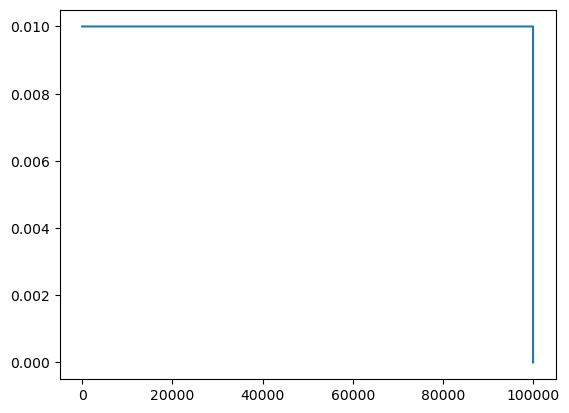

In [109]:
ela=1880
time=1000
save=1000
gamma=0.00395
model = glacierSim(ela=ela, time=time, save=save,gamma=gamma)
# plt.plot(glac.x, glac.topo)
# plt.plot(glac.x,glac.ice+glac.topo, color='b')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()
#print(model.dx)
anim = FuncAnimation(fig, model.run_model, model.frames, init_func=model.init(ax,ela=ela, time=time, save=save,gamma=gamma), blit=False, repeat=False)
vid = HTML(anim.to_jshtml())
print("ICE: ",model.ice)
print("SLOPE: ",model.ice_slope)
print("MASS BALANCE: ",model.b)
print("DONE")
#plt.plot(model.volume_change)
plt.plot(model.timestep_list)
#anim.save('animation.mp4', writer='ffmpeg', fps=15, dpi=100)
vid

In [112]:
ela = 1880
time = 1000
save = 1000
gamma =0.00395
precision = 0.000001
upper_bound=0.00396

while precision >= 1e-7:
    gamma_list = np.arange(gamma, upper_bound+precision, precision)
    for i in gamma_list:
        print(i)
        model = glacierSim(ela=ela, time=time, save=save, gamma=i)
        anim = FuncAnimation(fig, model.run_model, model.frames, init_func=model.init(ax, ela=ela, time=time, save=save, gamma=i), blit=False, repeat=False)
        vid = HTML(anim.to_jshtml())
        # display(vid)
        if 3626 <= model.glacier_extent <= 3646:
            print("Final gamma: ", i)
            precision /= 10
            gamma = i - precision
            break
        if model.glacier_extent > 3656:
            print('Extent overreached, ending')
            precision /= 10
            gamma = i - precision
            upper_bound=gamma
            break

0.00395


KeyboardInterrupt: 